In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.db_connect_pudl()

In [3]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

In [4]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)

In [5]:
bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])

In [6]:
# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu':np.sum})
bg_summed.reset_index(inplace=True)

In [7]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [8]:
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu'] / heat_rate['net_generation_mwh']
heat_rate

,plant_id,report_date,generator_id,fuel_consumed_mmbtu,net_generation_mwh,heat_rate_mmbtu_mwh
0,3,2009,1,4.564270e+06,221908.000,20.568299
1,3,2009,2,8.094252e+06,394031.000,20.542171
2,3,2009,3,2.613198e+07,1286393.000,20.314146
3,3,2009,4,3.232146e+07,1626547.000,19.871212
4,3,2009,5,8.941819e+07,4513101.000,19.813027
5,3,2009,A1ST,1.760776e+05,1122697.000,0.156834
6,3,2009,A2ST,1.373917e+05,1033733.000,0.132908
7,3,2010,1,9.048664e+06,435334.000,20.785567
8,3,2010,2,1.144207e+07,538495.000,21.248231
9,3,2010,3,1.914051e+07,906322.000,21.118888


In [20]:
# remove heat_rate_mmbtu_mwh values that are 'inf' and <= 0
heat_rate = heat_rate.replace([np.inf, -np.inf], np.nan).dropna(subset=["heat_rate_mmbtu_mwh"])
heat_rate = heat_rate[heat_rate.heat_rate_mmbtu_mwh > 0]

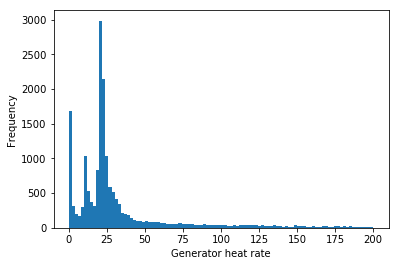

In [26]:
heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[0,200])
plt.xlabel('Generator heat rate')
plt.show()